In [125]:
import numpy as np
import time
from sklearn.externals import joblib
from sklearn import model_selection
import itertools
from sklearn import datasets
from sklearn import preprocessing
from sklearn import metrics


from keras import models
from keras import layers
from keras import optimizers
from keras import callbacks
from keras import backend

import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append('../')

from Sonar import StackedAutoEncoderCV as SAE

np.set_printoptions(3)

base_filename = '../Models/iris_sae_CLASS.jbl'

# Load Data 

In [186]:
dataset = datasets.load_iris()
data = dataset.data
target = dataset.target
class_names = dataset['target_names']

# Novelty Definition 

In [187]:
nov_cls = 1
nov_data = data[target == nov_cls]
nov_target = target[target == nov_cls]
nov_name = class_names[nov_cls]
# Known data
data = data[target != nov_cls]
target = target[target != nov_cls]
one_hot_target = -np.ones([target.shape[0], np.unique(target).shape[0]])
for i, cls in enumerate(np.unique(target)):
    one_hot_target[target == cls, i] = 1
class_names = np.setdiff1d(class_names, [nov_name])

# Load Models 

In [248]:
autoencoders = {}
encoders = {}
scalers = {}
for cls in class_names:
    sae = SAE.StackedAutoEncoderCV()
    sae.load(base_filename.replace('CLASS', cls))
    autoencoders[cls] = sae.network
    encoders[cls] = sae.network.get_encoder()
    scalers[cls] = sae.network.scaler

Loading from  ../Models/iris_sae_setosa.jbl
Loading from  ../Models/iris_sae_virginica.jbl


# Add Output Classification Layer 

In [246]:
print autoencoders['setosa'].encode(data[0:1])
s = scalers['setosa'].scale_
m = scalers['setosa'].mean_
W = encoders['setosa'].layers[0].get_weights()[0]
B = encoders['setosa'].layers[0].get_weights()[1]
encoders['setosa'].layers[0].set_weights( (W / s.reshape((s.shape[0],1)), B - np.dot(W.T,(m/s))))
#enc = backend.function([encoders['setosa'].layers[0].input],[encoders['setosa'].layers[-1].output])
enc = backend.function([encoders['setosa'].layers[0].get_input_at(0)],[encoders['setosa'].layers[-1].get_output_at(0)])
print enc([data[0:1]])[0]

[[0.373 0.26 ]]
[[0.373 0.26 ]]


In [249]:
print autoencoders['setosa'].predict(data[0:1])

s = scalers['setosa'].scale_
m = scalers['setosa'].mean_
W = autoencoders['setosa'].get_auto_encoder().layers[0].get_weights()[0]
B = autoencoders['setosa'].get_auto_encoder().layers[0].get_weights()[1]
autoencoders['setosa'].get_auto_encoder().layers[0].set_weights( (W / s.reshape((s.shape[0],1)), B - np.dot(W.T,(m/s))))


W = autoencoders['setosa'].get_auto_encoder().layers[-1].get_weights()[0]
B = autoencoders['setosa'].get_auto_encoder().layers[-1].get_weights()[1]
autoencoders['setosa'].get_auto_encoder().layers[-1].set_weights((W * s, B*s + m))
enc = backend.function([autoencoders['setosa'].get_auto_encoder().layers[0].get_input_at(0)],
                       [autoencoders['setosa'].get_auto_encoder().layers[-1].get_output_at(0)])
print enc([data[0:1]])[0]

[[5.146 3.475 1.484 0.176]]
[[5.146 3.475 1.484 0.176]]


In [183]:
# Incorporate Scaling to the first layer of each encoder
for cls in class_names: 
    s = scalers[cls].scale_
    m = scalers[cls].mean_
    W = encoders[cls].layers[0].get_weights()[0]
    B = encoders[cls].layers[0].get_weights()[1]
    encoders[cls].layers[0].set_weights((W / s.reshape((s.shape[0],1)), B - np.dot(W.T,(m/s))))

common_input = layers.Input(shape = [data.shape[1]])
graph_a = common_input
for lay in encoders['setosa'].layers:
    lay.name = 'setosa_' + lay.name
    lay.trainable = False
    graph_a = lay(graph_a)
graph_b = common_input
for lay in encoders['virginica'].layers:
    lay.name = 'virginica_' + lay.name
    lay.trainable = False
    graph_b = lay(graph_b)

merge_layer = layers.concatenate([graph_a, graph_b], axis=1)
hidden_layer = layers.Dense(10, activation='tanh')(merge_layer)
out_layer = layers.Dense(one_hot_target.shape[1], activation='tanh')(hidden_layer)
new_model = models.Model(inputs=[common_input], outputs=out_layer)
opt = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
new_model.compile(loss='mean_squared_error', optimizer=opt)

trn_desc = new_model.fit(data, one_hot_target, 
                         epochs = 200, 
                         batch_size = 100,
                         verbose = False,
                         shuffle=False)

{'activation': 'linear',
 'activity_regularizer': None,
 'batch_input_shape': (None, 10),
 'bias_constraint': None,
 'bias_initializer': {'class_name': 'Zeros', 'config': {}},
 'bias_regularizer': None,
 'dtype': u'float32',
 'kernel_constraint': None,
 'kernel_initializer': {'class_name': 'RandomUniform',
  'config': {'maxval': 0.05, 'minval': -0.05, 'seed': None}},
 'kernel_regularizer': None,
 'name': u'dense_66',
 'trainable': True,
 'units': 4,
 'use_bias': True}

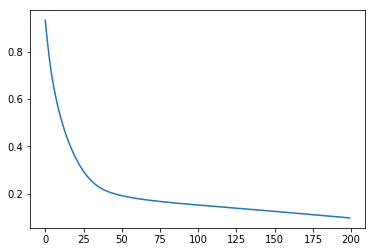

In [191]:
plt.plot(trn_desc.epoch, trn_desc.history['loss'], '-')

In [233]:
x.get_auto_encoder


AttributeError: 'StackedAutoEncoder' object has no attribute 'get_autoencoder'

In [201]:
Y = new_model.predict(data)
print metrics.confusion_matrix(np.argmax(Y, axis=1), np.argmax(one_hot_target, axis=1))
print metrics.classification_report(np.argmax(Y, axis=1), np.argmax(one_hot_target, axis=1))

[[48  1]
 [ 2 49]]
             precision    recall  f1-score   support

          0       0.96      0.98      0.97        49
          1       0.98      0.96      0.97        51

avg / total       0.97      0.97      0.97       100



Class
Known      AxesSubplot(0.125,0.125;0.775x0.755)
Novelty    AxesSubplot(0.125,0.125;0.775x0.755)
Name: Output, dtype: object

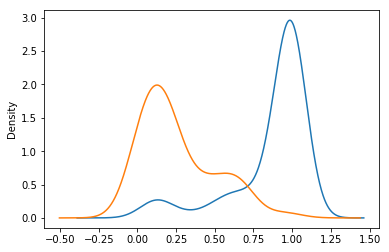

In [212]:
Y = new_model.predict(nov_data)
Y = np.max(Y, axis=1)

import pandas
df_known = pandas.DataFrame(columns=['Class','Output'])
df_known['Output'] = np.max(new_model.predict(data), axis=1)
df_known['Class'] = 'Known'
df_nov = pandas.DataFrame(columns=['Class','Output'])
df_nov['Output'] = np.max(new_model.predict(nov_data), axis=1)
df_nov['Class'] = 'Novelty'
df = pandas.concat((df_known, df_nov), axis=0)

df.groupby('Class').Output.plot(kind='kde')